First part: Data preparation, filtering and cleaning

In [8]:
import numpy as np
import pandas as pd
data = pd.read_csv('../data/BTCUSDT-1m-prep.csv', index_col=0)

In [9]:
data.shape

(2943309, 14)

In [10]:
data.dtypes

open_time           int64
open              float64
high              float64
low               float64
close             float64
volume            float64
num_trades          int64
taker_base_vol    float64
RSI               float64
KAMA              float64
PPO               float64
PVO               float64
ATR               float64
VWAP              float64
dtype: object

In [11]:
data.isnull().sum()

open_time         0
open              0
high              0
low               0
close             0
volume            0
num_trades        0
taker_base_vol    0
RSI               0
KAMA              0
PPO               0
PVO               0
ATR               0
VWAP              0
dtype: int64

In [13]:
data = data.drop(['taker_base_vol', 'num_trades'], axis=1)

In [14]:
data = data.rename(columns={'open_time': 'time'})

In [16]:
# Change UNIX milliseconds to datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')
data.head()

,time,open,high,low,close,volume,RSI,KAMA,PPO,PVO,ATR,VWAP
0,2017-09-01 11:59:00,4775.00,4775.00,4775.00,4775.00,0.070355,0.690908,4775.000000,0.767761,-27.705258,6.283042,4724.424643
1,2017-09-01 12:00:00,4775.00,4775.00,4775.00,4775.00,0.496307,0.690908,4775.000000,0.804877,-20.262442,6.274315,4724.506051
2,2017-09-01 12:01:00,4775.00,4775.00,4775.00,4775.00,0.000000,0.690908,4775.000000,0.835847,-32.342081,6.265601,4724.553523
3,2017-09-01 12:02:00,4779.99,4779.99,4779.99,4779.99,0.534126,0.847622,4775.031760,0.877563,-22.742588,6.263829,4724.649520
4,2017-09-01 12:03:00,4752.94,4752.94,4752.94,4752.94,0.416658,0.000000,4774.907113,0.825946,-18.986390,6.292699,4724.687684


In [17]:
data = data.drop_duplicates()

<Axes: xlabel='volume'>

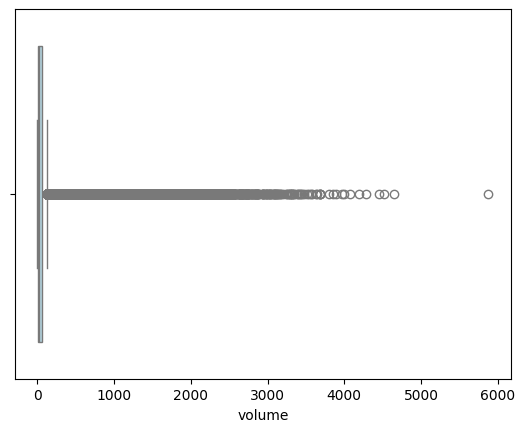

In [20]:
import seaborn as sns
sns.boxplot(x=data['volume'], color='lightblue')

In [26]:
threshold_volume = data['volume'].quantile(0.25)
print(f"Threshold volume: {threshold_volume}")
data_filtered = data[data['volume'] > threshold_volume]
print(f"Filtered data left: {data_filtered.shape[0]}")

Threshold volume: 11.698819
Filtered data left: 2207481


In [27]:
data_filtered.to_csv('../data/BTCUSDT-1m-prep-filtered.csv', index=False)

Second part: Data analysis with visualization

In [28]:
import matplotlib.pyplot as plt

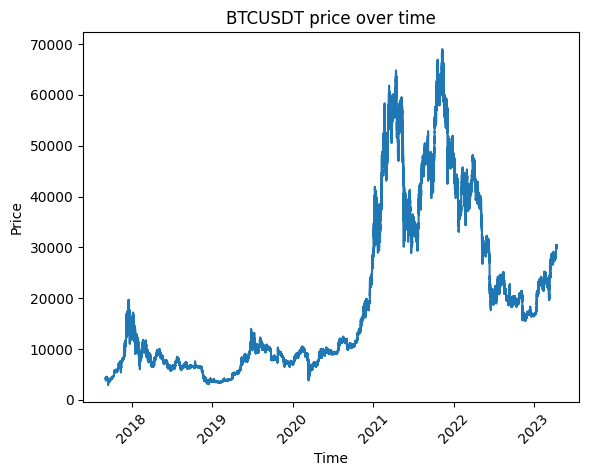

In [29]:
# Plotting the price
plt.plot(data_filtered['time'], data_filtered['close'])

# Add labels
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BTCUSDT price over time')

# Rotate tick marks on x-axis
plt.xticks(rotation=45)

# Display plot
plt.show()

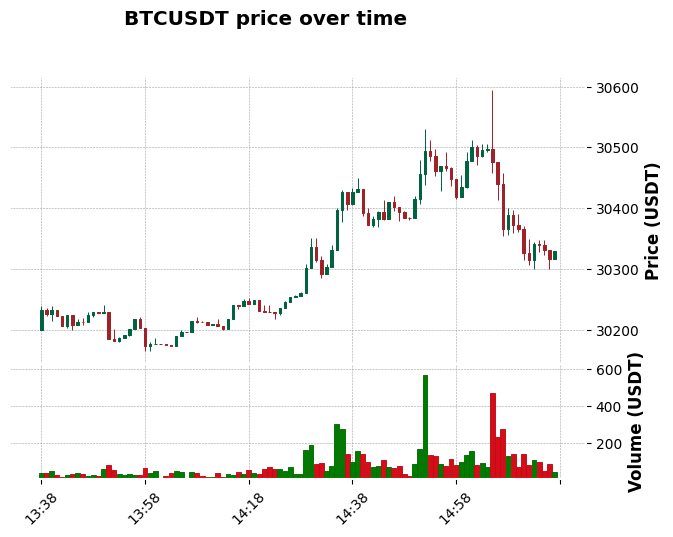

In [34]:
import mplfinance as mpf

# Prepare data index
data.index = pd.DatetimeIndex(data['time'])
candledata = data.tail(100)

# Plot candlestick chart
mpf.plot(
    candledata[['open', 'high', 'low', 'close', 'volume']], 
    type='candle', 
    style='charles', 
    volume=True, 
    title='BTCUSDT price over time',
    ylabel='Price (USDT)',
    ylabel_lower='Volume (USDT)')

# Show the plot
plt.show()

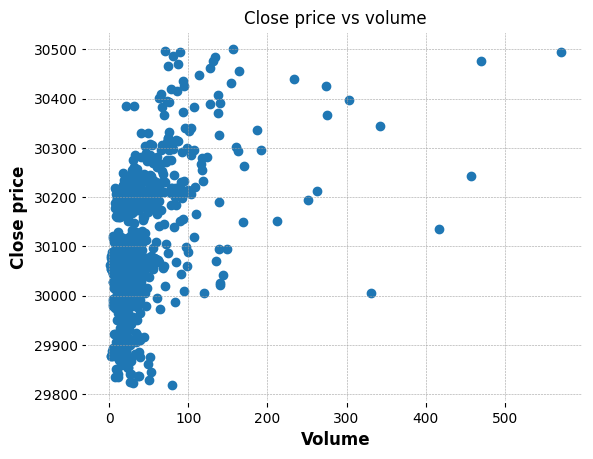

In [36]:
# Create scatter plot
data_scatter = data.tail(1000)
plt.scatter(data_scatter['volume'], data_scatter['close'])

# Add labels
plt.xlabel('Volume')
plt.ylabel('Close price')
plt.title('Close price vs volume')

# Display plot
plt.show()

Third part: Data analysis with statistics indicators

In [37]:
# Calculate 24h moving average by minutes
data['ma24h'] = data['close'].rolling(window=24*60).mean()
data[['close', 'ma24h']].tail(20)

,close,ma24h
time,,
2023-04-13 14:58:00,30418.71,30048.907986
2023-04-13 14:59:00,30435.34,30049.193160
2023-04-13 15:00:00,30477.19,30049.481715
2023-04-13 15:01:00,30500.92,30049.792618
2023-04-13 15:02:00,30485.59,30050.110153
2023-04-13 15:03:00,30495.44,30050.421403
2023-04-13 15:04:00,30497.35,30050.737403
2023-04-13 15:05:00,30476.31,30051.039444
2023-04-13 15:06:00,30440.51,30051.342778


In [50]:
# Calculate RSI by minutes over 24h

# Get the difference in price from previous step
delta = data['close'].diff()

# Get gain and loss
gain = delta.where(delta > 0.0, 0.0)
loss = - delta.where(delta < 0.0, - 0.0)

# Average gain and loss
avg_gain = gain.rolling('1d').mean()
avg_loss = loss.rolling('1d').mean()

# Calculate relative strength
rs = avg_gain / avg_loss

# Calculate RSI
data['rsi24h'] = 100 - (100 / (1 + rs))

# Show the data
data[['close', 'rsi24h', 'RSI']].tail(100)

,close,rsi24h,RSI
time,,,
2023-04-13 13:38:00,30232.91,50.060161,0.639018
2023-04-13 13:39:00,30225.16,50.198881,0.518314
2023-04-13 13:40:00,30231.77,50.287208,0.629829
2023-04-13 13:41:00,30222.70,50.340323,0.483002
2023-04-13 13:42:00,30206.00,50.248670,0.238354
...,...,...,...
2023-04-13 15:13:00,30341.00,52.211790,0.173793
2023-04-13 15:14:00,30339.93,51.954988,0.169260
2023-04-13 15:15:00,30330.96,51.751819,0.138457


In [51]:
# Calculate standard deviation by minutes over 24h
data['std24h'] = data['close'].rolling(window=24*60).std()

# Calculate upper and lower bands of Bollinger Bands
data['bb_upper'] = data['ma24h'] + 2 * data['std24h']
data['bb_lower'] = data['ma24h'] - 2 * data['std24h']

# Show the data
data[['close', 'ma24h', 'bb_upper', 'bb_lower']].tail(100)

,close,ma24h,bb_upper,bb_lower
time,,,,
2023-04-13 13:38:00,30232.91,30039.467021,30272.543381,29806.390661
2023-04-13 13:39:00,30225.16,30039.506375,30272.689049,29806.323701
2023-04-13 13:40:00,30231.77,30039.563160,30272.893317,29806.233003
2023-04-13 13:41:00,30222.70,30039.630375,30273.115809,29806.144941
2023-04-13 13:42:00,30206.00,30039.679514,30273.275249,29806.083778
...,...,...,...,...
2023-04-13 15:13:00,30341.00,30053.632924,30323.114438,29784.151409
2023-04-13 15:14:00,30339.93,30054.005313,30323.586322,29784.424303
2023-04-13 15:15:00,30330.96,30054.338049,30324.102873,29784.573224


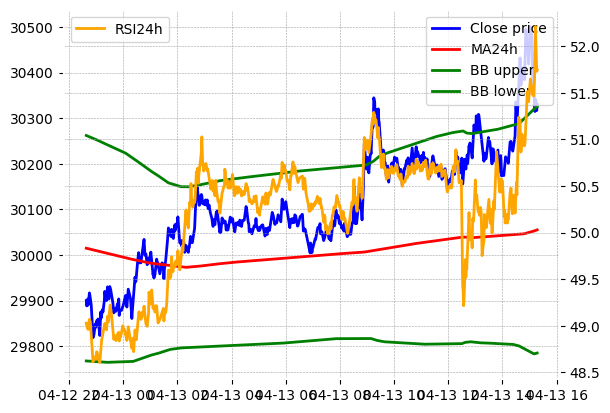

In [58]:
# Plot the data of close price with all indicators on the same chart
data_plot = data.tail(1000)
plt.plot(data_plot['time'], data_plot['close'], label='Close price', color='blue')
plt.plot(data_plot['time'], data_plot['ma24h'], label='MA24h', color='red')
plt.plot(data_plot['time'], data_plot['bb_upper'], label='BB upper', color='green')
plt.plot(data_plot['time'], data_plot['bb_lower'], label='BB lower', color='green')
plt.legend(loc='upper right')
plt.twinx()
plt.plot(data_plot['time'], data_plot['rsi24h'], label='RSI24h', color='orange')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.show()

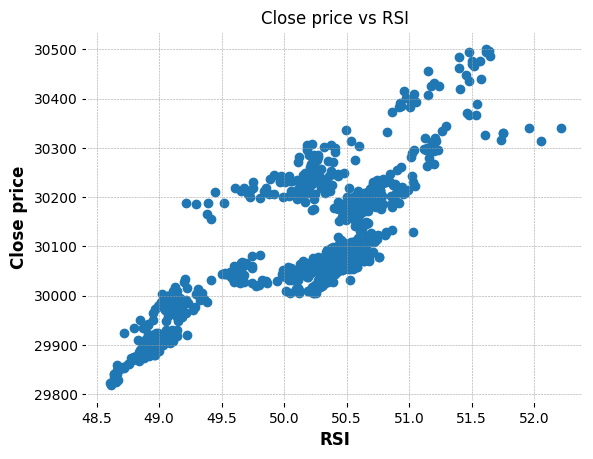

In [59]:
# Scatter plot of RSI and close price
data_scatter = data.tail(1000)
plt.scatter(data_scatter['rsi24h'], data_scatter['close'])
plt.xlabel('RSI')
plt.ylabel('Close price')
plt.title('Close price vs RSI')
plt.show()

Fourth part: Data analysis with pattern recognition

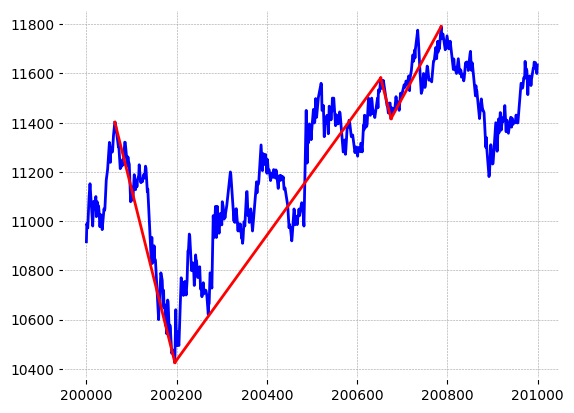

In [81]:
# Identity of head and shoulders pattern

# Return to normal index
data.index = np.arange(0, data.shape[0])

# Config
start = 200000
end = 201000
window = (end - start) // 3

# Get the highest price of each part
left_shoulder = data['close'].iloc[start:start+window].max()
left_shoulder_index = data['close'].iloc[start:start+window].idxmax()

after_left_shoulder = data['close'].iloc[left_shoulder_index:start+window].min()
after_left_shoulder_index = data['close'].iloc[left_shoulder_index:start+window].idxmin()

head = data['close'].iloc[start+window:end-window].max()
head_index = data['close'].iloc[start+window:end-window].idxmax()

right_shoulder = data['close'].iloc[end-window:end].max()
right_shoulder_index = data['close'].iloc[end-window:end].idxmax()

pre_right_shoulder = data['close'].iloc[end-window:right_shoulder_index].min()
pre_right_shoulder_index = data['close'].iloc[end-window:right_shoulder_index].idxmin()


# Plot the data
plt.plot(data['close'].iloc[start:end], color='blue')
plt.plot([left_shoulder_index, after_left_shoulder_index], [left_shoulder, after_left_shoulder], color='red')
plt.plot([after_left_shoulder_index, head_index], [after_left_shoulder, head], color='red')
plt.plot([head_index, pre_right_shoulder_index], [head, pre_right_shoulder], color='red')
plt.plot([pre_right_shoulder_index, right_shoulder_index], [pre_right_shoulder, right_shoulder], color='red')

plt.show()

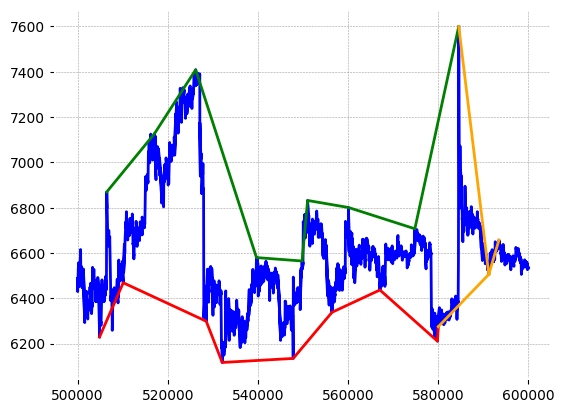

In [91]:
# Identity of the cup and handle pattern
parts = 10
start = 500000
end = 600000
window = (end - start) // parts

# Get the highest price of each part which is the top of the cup (except the last part)
tops = data.iloc[start:end-window].groupby(np.arange(len(data.iloc[start:end-window])) // window)['close'].max()
tops_index = data.iloc[start:end-window].groupby(np.arange(len(data.iloc[start:end-window])) // window)['close'].idxmax()

# Get the lowest price of each part which is the bottom of the cup (except the last part)
bottoms = data.iloc[start:end-window].groupby(np.arange(len(data.iloc[start:end-window])) // window)['close'].min()
bottoms_index = data.iloc[start:end-window].groupby(np.arange(len(data.iloc[start:end-window])) // window)['close'].idxmin()

# Get the highest price of the last part which is the top of the handle
handle_top = data['close'].iloc[end-window:end].max()
handle_top_index = data['close'].iloc[end-window:end].idxmax()

# Get the lowest price of the last part which is the bottom of the handle
handle_bottom = data['close'].iloc[end-window:handle_top_index].min()
handle_bottom_index = data['close'].iloc[end-window:handle_top_index].idxmin()

# Plot the data
plt.plot(data['close'].iloc[start:end], color='blue')
plt.plot(tops_index, tops, color='green')
plt.plot(bottoms_index, bottoms, color='red')
plt.plot([tops_index[len(tops_index)-1], handle_bottom_index], [tops[len(tops)-1], handle_bottom], color='orange')
plt.plot([bottoms_index[len(bottoms_index)-1], handle_bottom_index], [bottoms[len(bottoms)-1], handle_bottom], color='orange')
plt.plot([handle_top_index, handle_bottom_index], [handle_top, handle_bottom], color='orange')

plt.show()


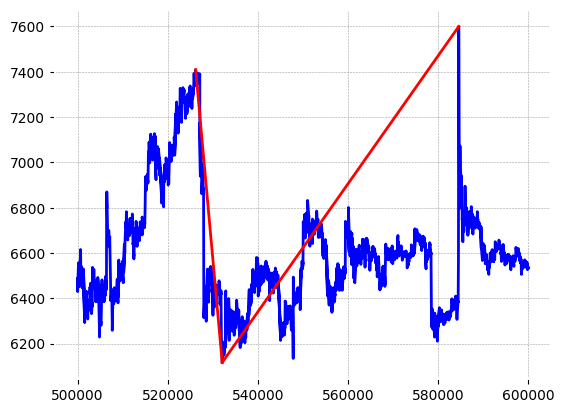

In [92]:
# Identity of the double top pattern
start = 500000
end = 600000
window = (end - start) // 2

# Get the highest price of each part
left_top = data['close'].iloc[start:start+window].max()
left_top_index = data['close'].iloc[start:start+window].idxmax()

right_top = data['close'].iloc[end-window:end].max()
right_top_index = data['close'].iloc[end-window:end].idxmax()

bottom_min = data['close'].iloc[left_top_index:right_top_index].min()
bottom_min_index = data['close'].iloc[left_top_index:right_top_index].idxmin()

# Plot the data
plt.plot(data['close'].iloc[start:end], color='blue')
plt.plot([left_top_index, bottom_min_index], [left_top, bottom_min], color='red')
plt.plot([right_top_index, bottom_min_index], [right_top, bottom_min], color='red')

plt.show()

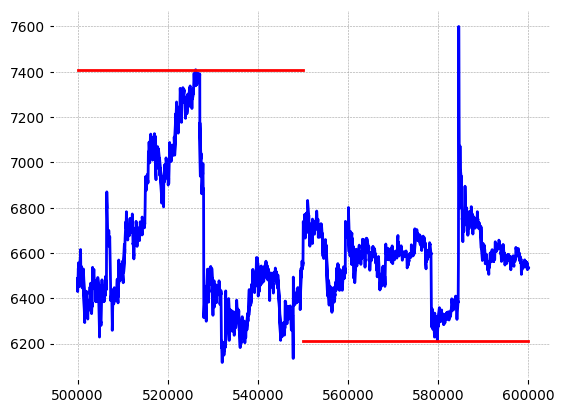

In [93]:
# Identify the flag pattern
start = 500000
end = 600000
window = (end - start) // 2

flagpole = data['close'].iloc[start:start+window].max()
flagpole_index = data['close'].iloc[start:start+window].idxmax()

flag = data['close'].iloc[start+window:end].min()
flag_index = data['close'].iloc[start+window:end].idxmin()

# Plot the data
plt.plot(data['close'].iloc[start:end], color='blue')
plt.plot([start, start+window], [flagpole, flagpole], color='red')
plt.plot([start+window, end], [flag, flag], color='red')

plt.show()

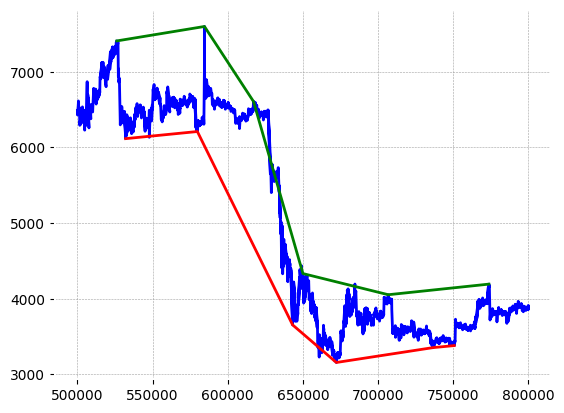

In [97]:
# Identify the triangle pattern
start = 500000
end = 800000
window = (end - start) // 6

tops = data.iloc[start:end].groupby(np.arange(len(data.iloc[start:end])) // window)['close'].max()
tops_index = data.iloc[start:end].groupby(np.arange(len(data.iloc[start:end])) // window)['close'].idxmax()

bottoms = data.iloc[start:end].groupby(np.arange(len(data.iloc[start:end])) // window)['close'].min()
bottoms_index = data.iloc[start:end].groupby(np.arange(len(data.iloc[start:end])) // window)['close'].idxmin()

# Plot the data
plt.plot(data['close'].iloc[start:end], color='blue')
plt.plot(tops_index, tops, color='green')
plt.plot(bottoms_index, bottoms, color='red')

plt.show()